In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import seaborn as sns

In [2]:
import warnings

In [3]:
import graphufs
plt.style.use("graphufs.plotstyle")

In [4]:
start_date = "2022-07-01T00"
end_date = "2022-07-31T00"

dates = pd.date_range(
    start_date,
    end_date,
    freq="6h",
)

In [5]:
varlist = [
    "temp",
    "uo",
    "vo",
    "so",
    "LW",
    "SW",
    "SSH",
]

In [6]:
extended_names = {
    "temp": "temperature",
    "uo": "u_component_of_current_velocity",
    "vo": "v_component_of_current_velocity",
    "so": "salinity",
    "LW": "LW_radiation_flux_into_the_ocean",
    "SW": "SW_radiation_flux_into_the_ocean",
    "SSH": "sea_surface_height",
}

In [7]:
selected_depths = (
    0.5,
    #3,
    #8,
    #16,
    #30,
    #56,
    94,
    #152,
    #272, 
    420
)

In [8]:
rds = xr.open_zarr(
    "gcs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree-subsampled/06h-freq/zarr/mom6.zarr",
    storage_options={"token": "anon"},
)

In [9]:
rds = rds[varlist]
rds = rds.sel(time=dates)
rds = rds.sel(z_l=list(selected_depths), method="nearest")

In [10]:
%%time
rds = rds.load()

CPU times: user 15 s, sys: 11.1 s, total: 26.1 s
Wall time: 17.4 s


In [11]:
rds.attrs["label"] = "Replay"

Normalization

In [12]:
norm = {
    k: xr.open_zarr(
        f"gcs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree-subsampled/06h-freq/zarr/mom6.fvstatistics.l10.1993-2019/{k}_by_level.zarr",
        storage_options={"token": "anon"},
    ).load()
    for k in ["mean", "stddev", "diffs_stddev"]
}

In [13]:
def plot_col(ax, xdalist, z_l, show_nnz, do_diff, do_log, quickplot):
    warnings.filterwarnings("error")
    thedata = {}
    for xda, label in zip(
        xdalist,
        ["Replay"],
    ):
        gkey = xdalist[0].name
        if len(xdalist) > 1:
            ekey = xdalist[1].name
        else:
            ekey = gkey
        local = xda.sel(z_l=z_l, method="nearest", drop=True).copy() if z_l is not None else xda.copy()
        if quickplot:
            lonidx = np.random.randint(low=0, high=len(local.lon), size=(50,))
            latidx = np.random.randint(low=0, high=len(local.lat), size=(50,))
            local = local.isel(lon=lonidx,lat=latidx)
        if do_log:
            transform = np.log if do_diff else np.log10
            cond = local > 0.
            thresh_transform = lambda x: xr.where(cond, transform(x.where(cond)), 0.)
            try:
                local = thresh_transform(local)
            except RuntimeWarning:
                
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    local = thresh_transform(local)

                msg = f"Trouble running np.log on {label} {gkey}"
                if level is not None:
                    msg += f" level {level}"
                print(msg)
                pass
                
        if do_diff:
            local = local.diff("time")

        # normalization, only for do_diff
        localnorm = 1
        localloc = 0
        if do_diff:
            if not do_log:
                localnorm = norm["diffs_stddev"][gkey]
            elif f"log_{gkey}" in norm["diffs_stddev"]:
                localnorm = norm["diffs_stddev"][f"log_{gkey}"]

        if isinstance(localnorm, xr.DataArray):
            if z_l is not None:
                localnorm = localnorm.sel(z_l=z_l, method="nearest", drop=True)
            localnorm = localnorm.values

        if np.isnan(local).any().values:
            msg = f"Found NaNs in {label} {gkey}"
            if z_l is not None:
                msg += f" level {z_l}"
            print(msg)

        thedata[label] = local.values.flatten() / localnorm
        
    sns.violinplot(
        thedata,
        ax=ax,
        cut=0,
    )
    title = " ".join([x.upper() for x in ekey.split("_")])
    if do_log:
        title = f"log({title})" if do_diff else f"log10({title})"
        
    if do_diff:
        title = f"diff({title})\n/std(diff({title}))"
    ax.set(title=title if ax.get_subplotspec().is_first_row() else "")
    if show_nnz:
        ax.axhline(y=0, color="gray", alpha=.5)
        negative = {key: np.sum(val < 0) for key, val in thedata.items()}
        ax.set(
            xticks=ax.get_xticks(),
            xticklabels = [f"{key}\n({val})" for key,val in negative.items()],
        )


In [14]:
def histplot(gkeylist, depths=selected_depths, do_diff=False, sharey=False, logvars=tuple(), show_nnz_vars=tuple(), quickplot=False):

    ncols = len(gkeylist)
    nrows = len(depths) if "z_l" in rds[gkeylist[0]].dims else 1
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*4), constrained_layout=True, sharey=sharey, sharex=True)
    
    for gkey, axc in zip(gkeylist, axs.T):
        xdalist = [rds[gkey]]
        do_log = gkey in logvars
        show_nnz = gkey in show_nnz_vars
        
        kw = {"show_nnz": show_nnz, "do_diff": do_diff, "do_log": do_log, "quickplot": quickplot}
        
        if "z_l" in rds[gkey].dims:
            if nrows == 1:
                axc = [axc]
            for z_l, ax in zip(depths, axc):
                plot_col(ax, xdalist, z_l=z_l, **kw)
                ax.set(
                    ylabel=f"~{int(z_l)} m" if ax.get_subplotspec().is_first_col() else "",
                )
        else:
            plot_col(axc, xdalist, z_l=None, **kw)
    return fig, axs

In [15]:
vars2d = [v for v in varlist if "z_l" not in rds[v].dims]
vars3d = [v for v in varlist if "z_l" in rds[v].dims]

## 2D Fields

In [16]:
vars2d

['LW', 'SW', 'SSH']

In [17]:
targets2d = vars2d

In [18]:
fig_dir = "figures/distributions"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

Found NaNs in Replay LW
Found NaNs in Replay SW
Found NaNs in Replay SSH


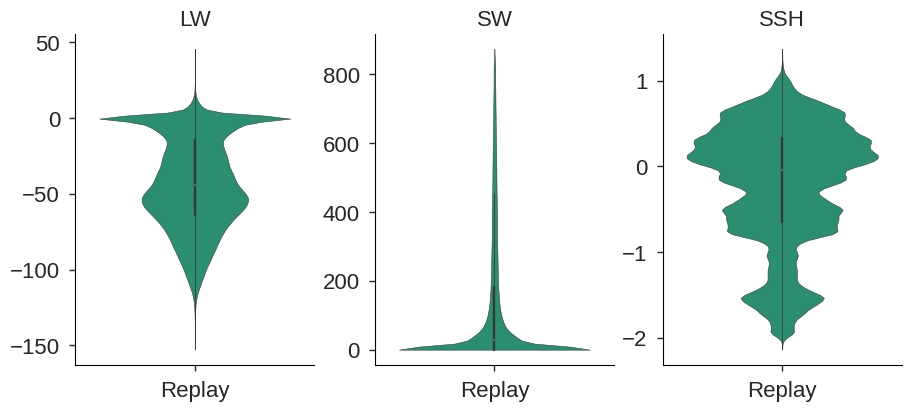

In [19]:
fig, axs = histplot(targets2d, logvars=());
fig.savefig(f"{fig_dir}/surface_ocean_variables.jpeg", bbox_inches="tight", dpi=300)

Found NaNs in Replay LW
Found NaNs in Replay SW
Found NaNs in Replay SSH
CPU times: user 2min 45s, sys: 4.2 s, total: 2min 50s
Wall time: 1min 19s


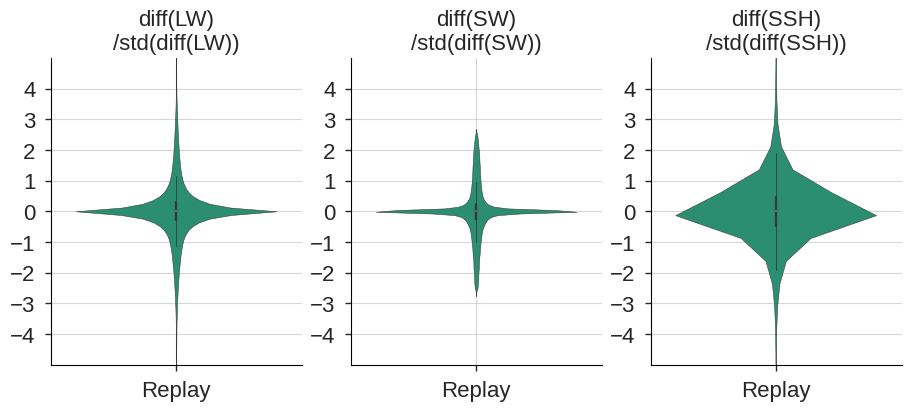

In [20]:
%%time
fig, axs = histplot(targets2d, do_diff=True, logvars=[]);
for v, ax in zip(targets2d, axs):
    ax.set(
        ylim=(-5, 5),
        yticks=np.arange(-4,5),
    )
    ax.grid(visible=True, alpha=0.5);

fig.savefig(f"{fig_dir}/surface_ocean_variables_diff.jpeg", bbox_inches="tight", dpi=300)

## 3D Fields

In [21]:
vars3d

['temp', 'uo', 'vo', 'so']

Found NaNs in Replay temp level 0.5
Found NaNs in Replay temp level 94
Found NaNs in Replay temp level 420
Found NaNs in Replay uo level 0.5
Found NaNs in Replay uo level 94
Found NaNs in Replay uo level 420
Found NaNs in Replay vo level 0.5
Found NaNs in Replay vo level 94
Found NaNs in Replay vo level 420
Found NaNs in Replay so level 0.5
Found NaNs in Replay so level 94
Found NaNs in Replay so level 420
CPU times: user 10min 22s, sys: 16 s, total: 10min 38s
Wall time: 5min 10s


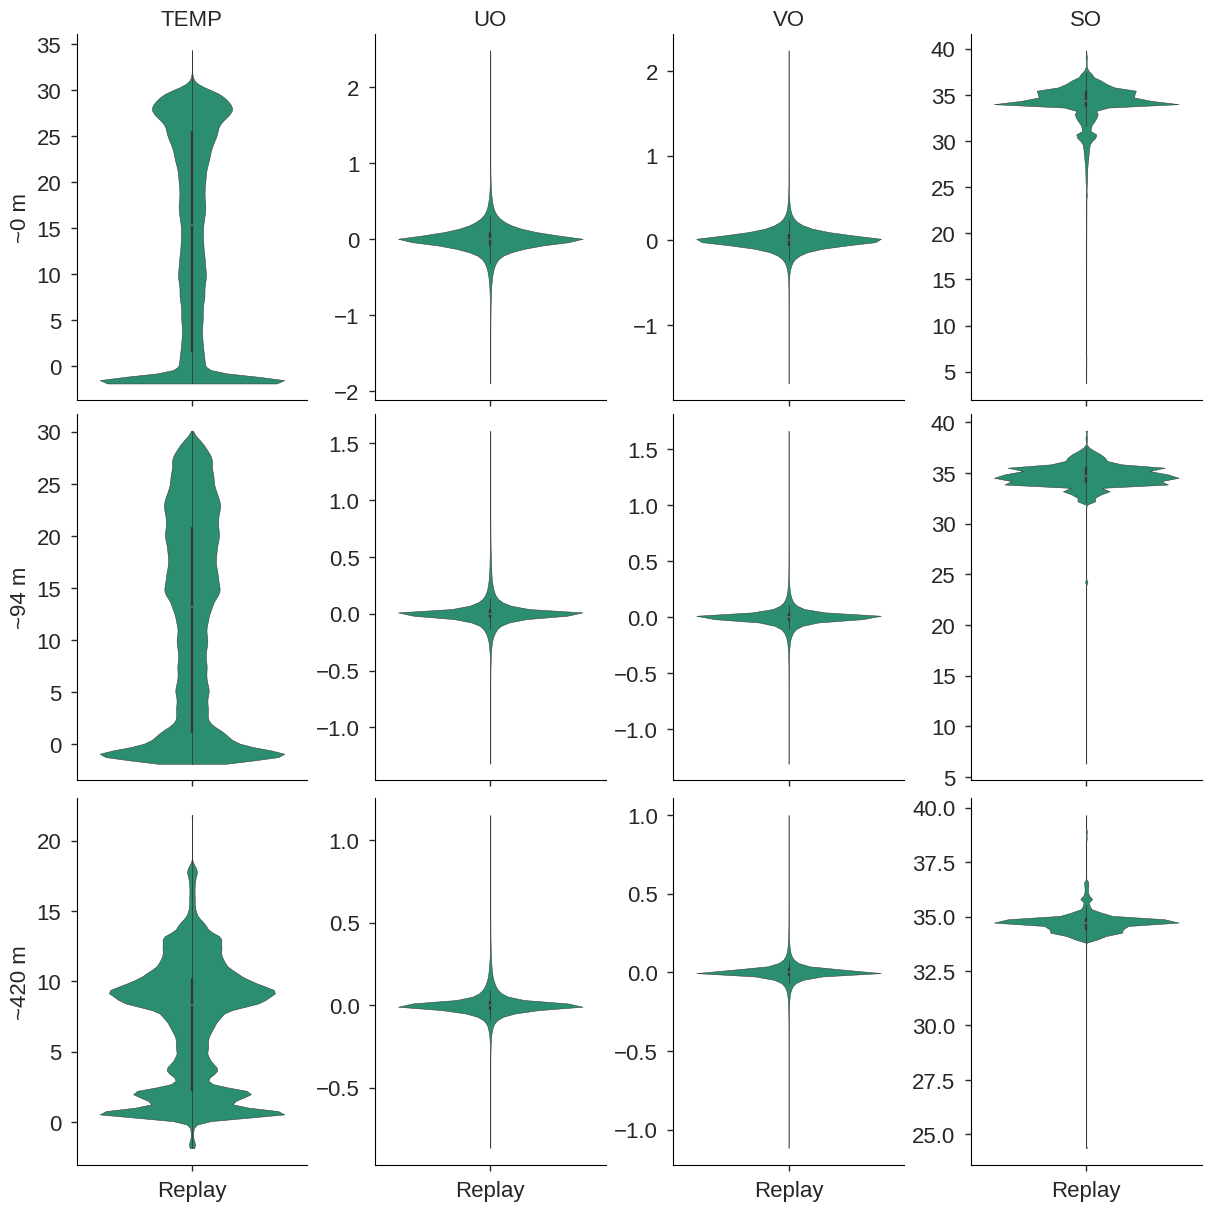

In [22]:
%%time
fig, axs = histplot(vars3d, logvars=());
fig.savefig(f"{fig_dir}/3d_ocean_variables.jpeg", bbox_inches="tight", dpi=300)

Found NaNs in Replay temp level 0.5
Found NaNs in Replay temp level 94
Found NaNs in Replay temp level 420
Found NaNs in Replay uo level 0.5
Found NaNs in Replay uo level 94
Found NaNs in Replay uo level 420
Found NaNs in Replay vo level 0.5
Found NaNs in Replay vo level 94
Found NaNs in Replay vo level 420
Found NaNs in Replay so level 0.5
Found NaNs in Replay so level 94
Found NaNs in Replay so level 420
CPU times: user 10min 2s, sys: 14.6 s, total: 10min 16s
Wall time: 5min 2s


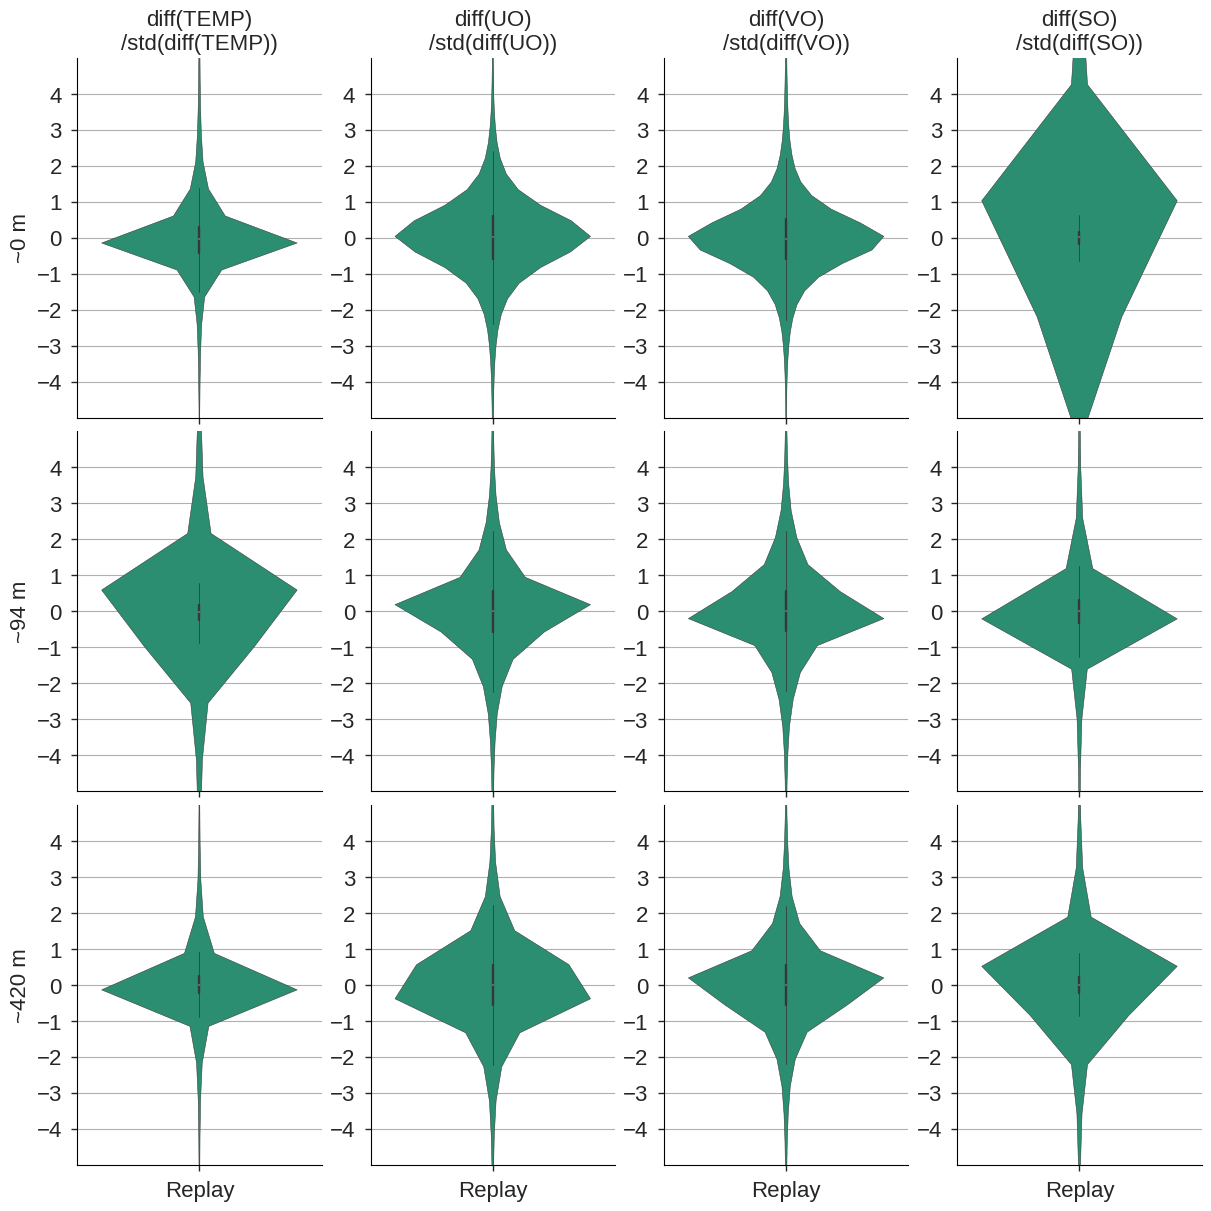

In [23]:
%%time
fig, axs = histplot(vars3d, do_diff=True, logvars=());
for ax in axs.flatten():
    ax.set(
        ylim=(-5, 5),
        yticks=np.arange(-4,5),
    )
    ax.grid(visible=True);
fig.savefig(f"{fig_dir}/3d_ocean_variables_diff.jpeg", bbox_inches="tight", dpi=300)